# Modeling an Autoregressive Process

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Predicting the average weekly foot traffic in a retail store

In [6]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/foot_traffic.csv')

df = pd.read_csv(url1)

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


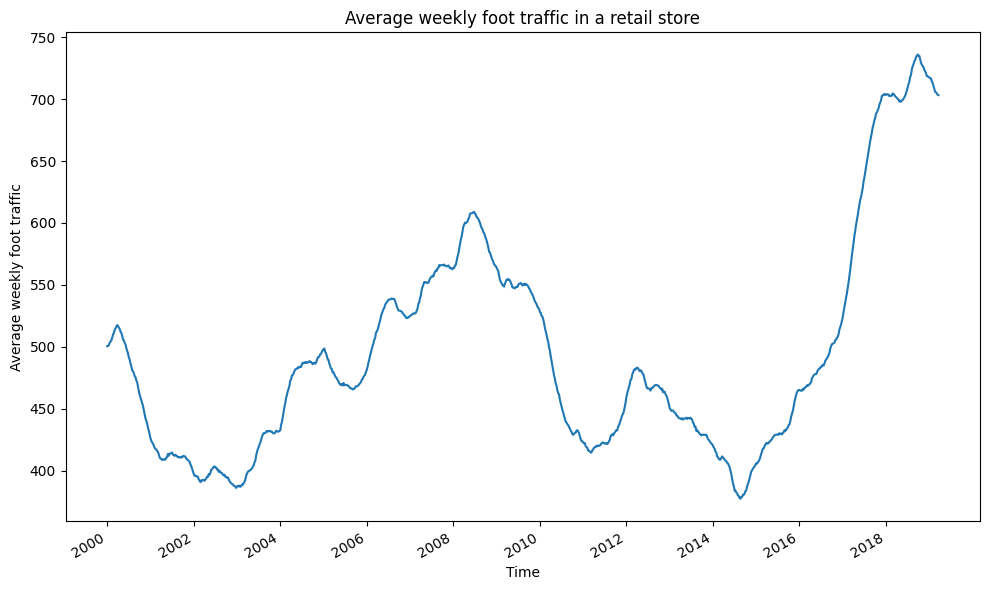

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
ax.set_title('Average weekly foot traffic in a retail store')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()